In [1]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
import albumentations as A
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import cv2
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict

In [52]:
class MyDataset(Dataset):
    def __init__(self,
                 images_folder,
                 transform=None,
                 *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.images_folder = images_folder

        self.transform = transform if transform else \
            A.Compose(
                [
                    ToTensorV2(),
                ]
            )
        self.model_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

        self.folder_to_files = defaultdict(list) # folder: [file1, file2]
        self.image_folders = []
        self._read_images_names()

    def _read_images_names(self):
        for root, dirs, files in os.walk(self.images_folder):
            for image_name in files:
                img_path = os.path.join(root, image_name)

                _, ext = os.path.splitext(img_path)
                if ext not in ['.png', '.jpg', '.jpeg']:
                    continue
                self.folder_to_files[root].append(img_path)

            if len(self.folder_to_files.get(root, [])):
                self.image_folders.append(root)

    def __len__(self):
        return len(self.folder_to_files)
    
    def get_original_image(self, idx):
        image_folder = self.image_folders[idx]

        img_path = self.folder_to_files[image_folder][
            np.random.randint(
                len(self.folder_to_files[image_folder])
            )
        ]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image

    def __getitem__(self, idx):
        image_folder = self.image_folders[idx]
        res = []

        for img_path in self.folder_to_files[image_folder]:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = self.transform(image=image)["image"]
            image = self.model_transform(image)
            res.append(image.float())

        return torch.stack(res)

In [53]:
my_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/VisDrone2020-CC/sequences")

In [56]:
len(my_dataset)

112

In [57]:
class EmbeddingsExtractor(pl.LightningModule):

    def __init__(self):
        super(EmbeddingsExtractor, self).__init__()

        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
        )

        for name, param in self.model.named_parameters():
            # if "fc" in name or "layer4" in name or "layer3" in name:
            #     continue
            param.requires_grad = False

        # self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def get_embedings(self, dataset):
        dataloader = DataLoader(dataset, batch_size=1)
        self.eval()
        embeds = []
        with torch.no_grad():
            for batch in dataloader:
                item_dataset = TensorDataset(batch[0])
                item_dataloader = DataLoader(item_dataset, batch_size=30)
                item_outputs = []
                for (item_batch,) in item_dataloader:
                    item_batch = item_batch.to(self.device)
                    outputs = self(item_batch)
                    item_outputs.append(outputs)
                embeds.append(torch.cat(item_outputs).mean(axis=0))
        return torch.stack(embeds)

In [58]:
my_dataset_1, my_dataset_2 = torch.utils.data.Subset(
    my_dataset, 
    range(
        len(my_dataset) // 2)
    ), \
    torch.utils.data.Subset(
        my_dataset, 
        range(len(my_dataset) // 2, 
        len(my_dataset))
    )

In [59]:
import torch.utils
import torch.utils.data


def get_embeds_example(dataset, extractor, subsample_size=1_000, random_seed=42):
    np.random.seed(random_seed)
    subsample_size = min(subsample_size, len(dataset))
    idxs = np.random.choice(range(len(dataset)), subsample_size, replace=False)
    subset = torch.utils.data.Subset(dataset, idxs)
    
    embeds = extractor.get_embedings(subset)
    return embeds

In [60]:
extractor = EmbeddingsExtractor()

In [17]:
get_embeds_example(my_dataset, extractor, 10).shape

torch.Size([10, 512])

In [18]:
embeds1, embeds2 = get_embeds_example(my_dataset_1, extractor, subsample_size=100, random_seed=42), \
    get_embeds_example(my_dataset_2, extractor, subsample_size=100, random_seed=69)

In [19]:
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error as mse
from itertools import product

def _mean_similarity(emb1, emb2):

    sim_sum = 0
    for el1 in emb1:
        for el2 in emb2:
            sim_sum += np.dot(el1, el2) / (np.linalg.norm(el1) * np.linalg.norm(el2))
    
    return sim_sum / len(emb1) / len(emb2)


def embeds_list_similarity(emb1, emb2):
    emb1, emb2 = np.array(emb1), np.array(emb2)

    return np.mean(_mean_similarity(emb1, emb2))

In [20]:
embeds_list_similarity(embeds1, embeds2)

0.715364600636293

In [21]:
def get_similarities(ds1, ds2, subsample_size=100, iters=100):
    similarities_list = []
    for seed in tqdm(range(iters)):
        embeds1, embeds2 = get_embeds_example(
            ds1, extractor, random_seed=seed, subsample_size=subsample_size), get_embeds_example(
                ds2, extractor, random_seed=seed**2, subsample_size=subsample_size)
        similarities_list.append(embeds_list_similarity(embeds1, embeds2))
    return similarities_list

In [23]:
similarities_list = get_similarities(my_dataset_1, my_dataset_2, subsample_size=56, iters=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
similarities_list

[0.715364600636293]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.2153646, 0.2253646, 0.2353646, 0.2453646, 0.2553646, 0.2653646,
        0.2753646, 0.2853646, 0.2953646, 0.3053646, 0.3153646, 0.3253646,
        0.3353646, 0.3453646, 0.3553646, 0.3653646, 0.3753646, 0.3853646,
        0.3953646, 0.4053646, 0.4153646, 0.4253646, 0.4353646, 0.4453646,
        0.4553646, 0.4653646, 0.4753646, 0.4853646, 0.4953646, 0.5053646,
        0.5153646, 0.5253646, 0.5353646, 0.5453646, 0.5553646, 0.5653646,
        0.5753646, 0.5853646, 0.5953646, 0.6053646, 0.6153646, 0.6253646,
        0.6353646, 0.6453646, 0.

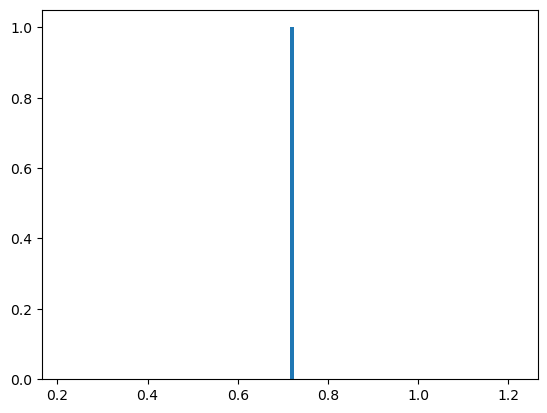

In [24]:
plt.hist(similarities_list, bins=100, range=[min(similarities_list), max(similarities_list)])

In [61]:
test_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/VisDrone2019-MOT-val/sequences")
len(test_dataset), len(my_dataset)

(7, 112)

In [26]:
similarities_test_list_1 = get_similarities(my_dataset_1, test_dataset, subsample_size=56, iters=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
similarities_test_list_1

[0.6796604285434801]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.2153646, 0.2253646, 0.2353646, 0.2453646, 0.2553646, 0.2653646,
        0.2753646, 0.2853646, 0.2953646, 0.3053646, 0.3153646, 0.3253646,
        0.3353646, 0.3453646, 0.3553646, 0.3653646, 0.3753646, 0.3853646,
        0.3953646, 0.4053646, 0.4153646, 0.4253646, 0.4353646, 0.4453646,
        0.4553646, 0.4653646, 0.4753646, 0.4853646, 0.4953646, 0.5053646,
        0.5153646, 0.5253646, 0.5353646, 0.5453646, 0.5553646, 0.5653646,
        0.5753646, 0.5853646, 0.5953646, 0.6053646, 0.6153646, 0.6253646,
        0.6353646, 0.6453646, 0.

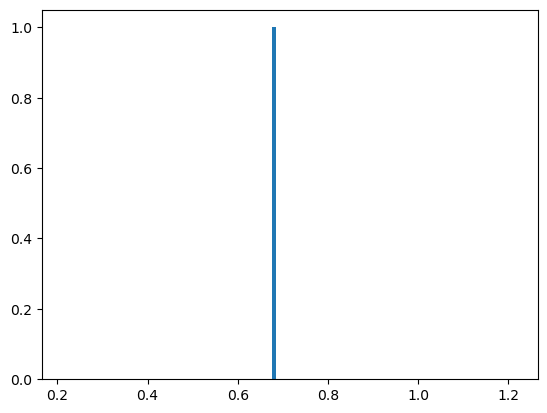

In [27]:
plt.hist(similarities_test_list_1, bins=100, range=[min(similarities_list), max(similarities_list)])

In [28]:
similarities_test_list_2 = get_similarities(my_dataset_2, test_dataset, subsample_size=56, iters=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
similarities_test_list_2

[0.6735617188470704]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0.2153646, 0.2653646, 0.3153646, 0.3653646, 0.4153646, 0.4653646,
        0.5153646, 0.5653646, 0.6153646, 0.6653646, 0.7153646, 0.7653646,
        0.8153646, 0.8653646, 0.9153646, 0.9653646, 1.0153646, 1.0653646,
        1.1153646, 1.1653646, 1.2153646]),
 <BarContainer object of 20 artists>)

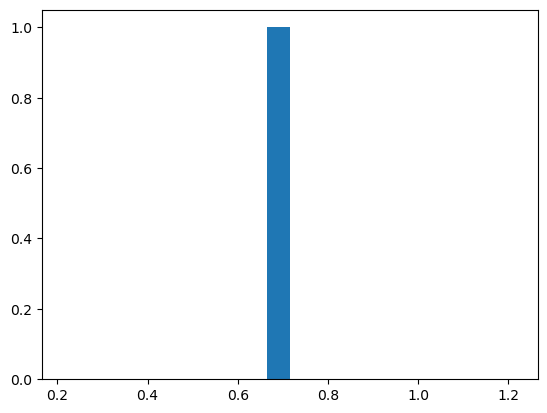

In [29]:
plt.hist(similarities_test_list_2, bins=20, range=[min(similarities_list), max(similarities_list)])

In [70]:
def plot_images(dataset, cnt, random_state=42):
    np.random.seed(random_state)

    idxs = np.random.choice(range(len(dataset)), cnt, replace=False)

    rows = int(np.ceil(cnt ** 0.5))
    cols = cnt // rows
    rows = int(np.ceil(cnt / cols))
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    for i, idx in enumerate(idxs):
        axs[i // cols, i % cols].imshow(dataset.get_original_image(idx))

    plt.show()

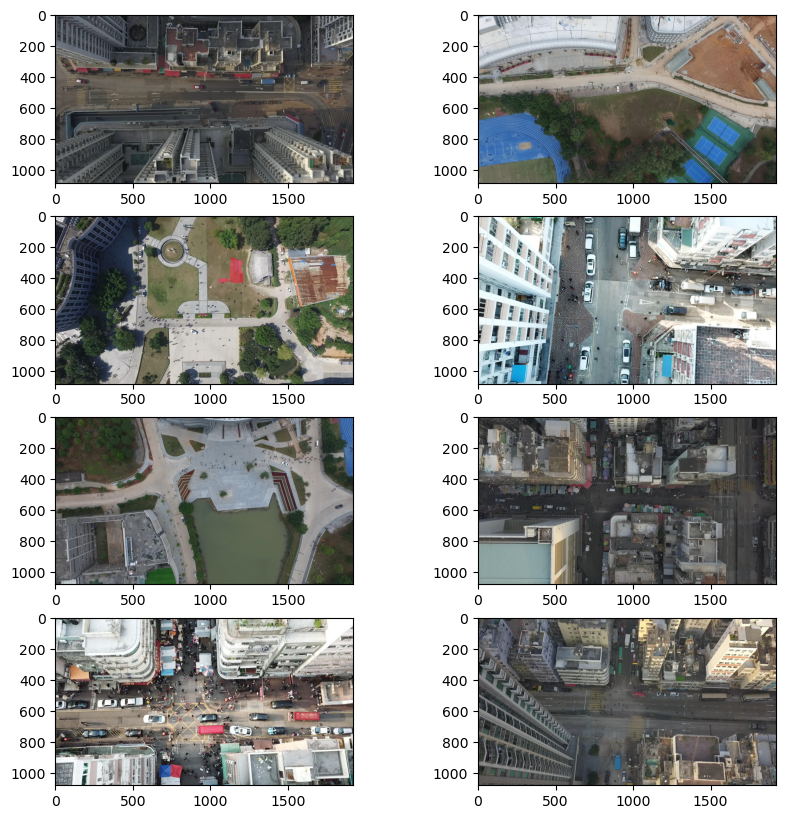

In [75]:
plot_images(my_dataset, 8)

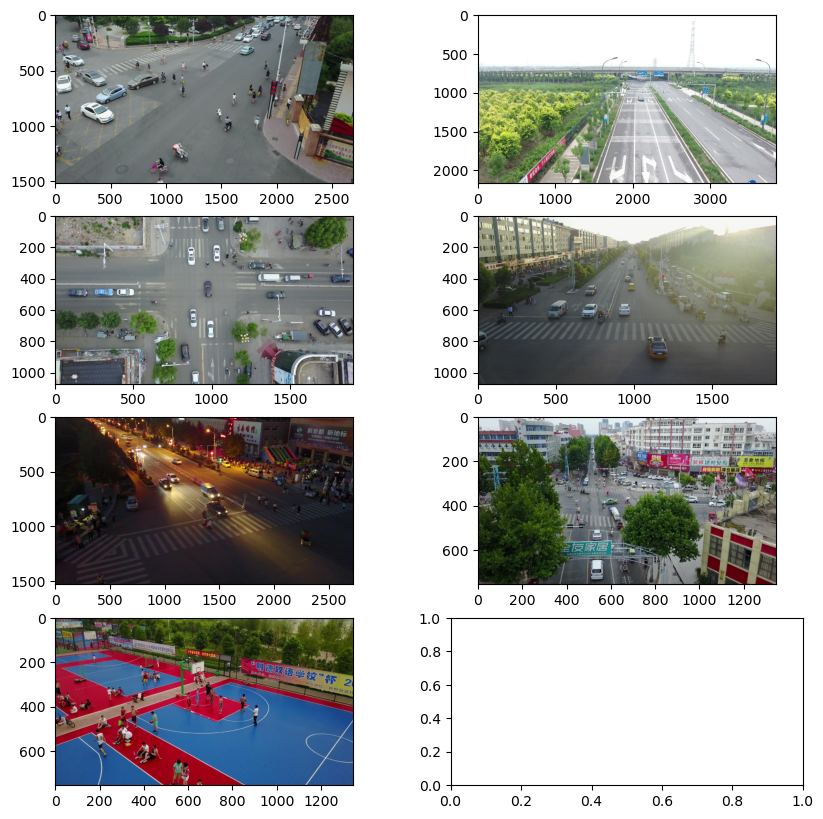

In [73]:
plot_images(test_dataset, 7)